# Gearbox

Example taken from: Chaudhuri, S., & Solar-Lezama, A. (2010, June). Smooth interpretation. In Proceedings of the 31st ACM SIGPLAN Conference on Programming Language Design and Implementation (pp. 279-291).

```
s1, s2, s3, s4 = ?

while(t < T):

    v = update_v

    if gear == 1 and v >= s1 {
        gear = 0, nxt = 2, w=0.8;
    } elif gear == 2 and v >= s2 {
        gear = 0, nxt = 3, w=0.8;
    } elif gear == 2 and v >= s2 {
        gear = 0, nxt = 3, w=0.8;
    } elif gear == 2 and v >= s2 {
        gear = 0, nxt = 3, w=0.8;
    } elif w < 0 and gear == 0 {
        gear = nxt;
    }

    w = w - 0.1;
```

Velocity evolves according to:
$$ \frac{d \textit{v}}{dt} = \begin{cases} v \cdot \alpha(i, v) + \textit{gauss}(5., 1.) & \text{if gear==i} \\
                                        -0.0005 v^2 + \textit{gauss}(0., 0.5) & \text{if gear==0}  \end{cases} $$

where $\alpha(i,v) = \frac{1}{1 + \frac{(v-p_i)^2}{25}}$ and $p_i = (5, 15, 25, 40, 60)$.

### Original Model

In [1]:
# Cerchiamo un'approssimazione ragionevole per alpha

#import matplotlib.pyplot as plt
#
#lb = [0, 10, 20, 30, 50]
#ub = [10, 20, 30, 50, 100]
#p = [5,15, 25, 40, 60]
#
#for i in range(5):
#    v = np.linspace(lb[i], ub[i], 100)
#    y = [1/(1+(vi - p[i])**2/25) for vi in v]
#    
#    print('Average alpha {}: '.format(i+1), np.mean(y))

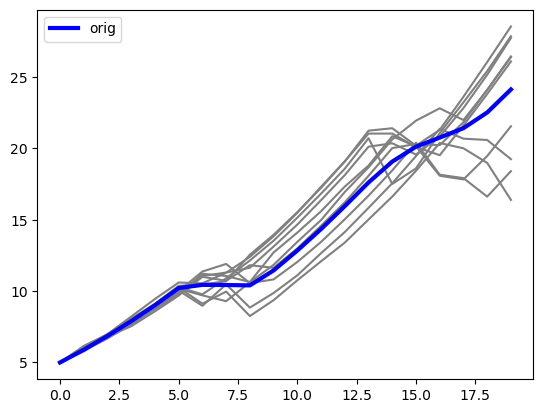

In [2]:
from cps.original_models import *
      

orig_params = {'T': 20,   # time steps
               'init_v': 5.,  # initial velocity
               'gear': 1,      # initial gear
               's1': 10.,
               's2': 20.}      

orig_traj = generate_traj(gearbox, 1000, orig_params)

plot_traj_set(orig_traj, single_traj=10, color='blue', label='orig')

In [3]:
#export orig_traj to csv
import pandas as pd
#consider only 40 trajectories from time 0 to 20
plot_trajectories = orig_traj[:40, 0:22]
#transpose the array so that each row is a time step and each column is a trajectory
plot_trajectories = plot_trajectories.T

df = pd.DataFrame(plot_trajectories)
df.to_csv('gearbox_orig_traj.csv', index=False)

## SOGA

In [4]:
from optimization import *
torch.set_default_dtype(torch.float64)

Loss value: tensor(17488.4464, grad_fn=<NegBackward0>)


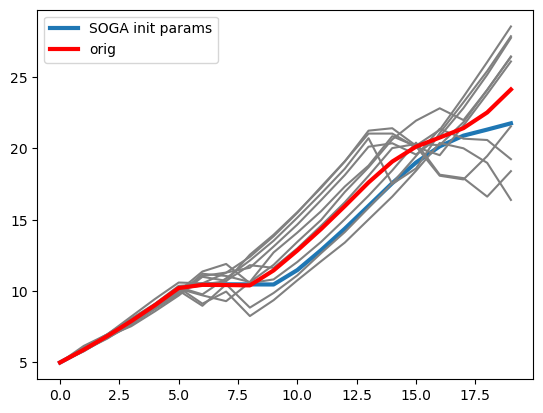

In [5]:
# this is to check that for the correct value of the parameter, the loss is negative and the mean produced by SOGA is almost exactly the true mean

# creates the cfg for the SOGA model
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/Gearbox2.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

# initialize parameters
params = {'s1':10., 's2':20.}
params_dict = initialize_params(params)

# computes SOGA output
output_dist = start_SOGA(cfg, params_dict, pruning='ranking')

# loss
T = orig_params['T']
idx = list(range(1, T))
print('Loss value:', neg_log_likelihood(orig_traj, output_dist, idx))

# plot
y_init = output_dist.gm.mean()[:T].detach()
plt.plot(range(T), y_init, lw=3, label='SOGA init params')
plot_traj_set(orig_traj, single_traj=10, color='red', label='orig')


Loss value: tensor(46926.8235, grad_fn=<NegBackward0>)


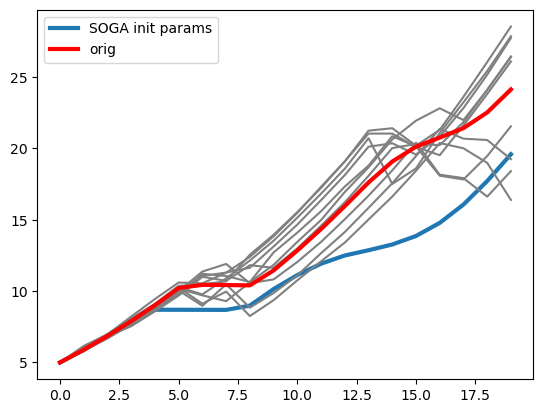

In [6]:
# we choose as initial value of the parameters values for which the loss is higher 
# and there is a significant difference in the mean trajectories

# new cfg for SOGA
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/Gearbox2.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

# initial parameters
init_params = {'s1':8., 's2':12.}
params_dict = initialize_params(init_params)  

# computes SOGA output
output_dist = start_SOGA(cfg, params_dict)

# loss
print('Loss value:', neg_log_likelihood(orig_traj, output_dist, idx))

# plot
y_init = output_dist.gm.mean()[:T].detach()
plt.plot(range(T), y_init, lw=3, label='SOGA init params')
plot_traj_set(orig_traj, single_traj=10, color='red', label='orig')

y = []
y_var = []
for i in range(20):
    y.append(output_dist.gm.mean()[output_dist.var_list.index('v['+ str(i) +']')].detach().numpy())
    y_var.append(torch.sqrt(output_dist.gm.cov()[output_dist.var_list.index('v['+ str(i) +']'), output_dist.var_list.index('v['+ str(i) +']')]).detach().numpy())

df = pd.DataFrame({'Y_mean': y, 'Y_std': y_var})
df.to_csv('gearbox_init.csv', index=False)


s1: 8.299999999997949 s2: 12.299999999999729  loss: 46926.82353126823
s1: 8.60035251249577 s2: 12.599227271848665  loss: 43339.54307234601
s1: 8.901194050065225 s2: 12.896615275357528  loss: 39878.83032968353
s1: 9.201585319889391 s2: 13.190904089598332  loss: 36724.44283687238
s1: 9.46270238108428 s2: 13.481655022826596  loss: 34177.72316951168
s1: 9.684722523270601 s2: 13.768744754067951  loss: 32107.707292167433
s1: 9.878208111062758 s2: 14.051682235752173  loss: 30219.89538553782
s1: 10.032872286709015 s2: 14.329928967070009  loss: 28538.721769811604
s1: 10.115742772664076 s2: 14.602905584119558  loss: 27116.591135121493
s1: 10.114985675682146 s2: 14.870250074634368  loss: 25868.943842120658
s1: 10.05205361359633 s2: 15.131722300659243  loss: 24633.530607299086
s1: 9.952270809486741 s2: 15.386927277535422  loss: 23420.909607459733
s1: 9.836689429658541 s2: 15.63524820636838  loss: 22325.03459747363
s1: 9.71986507441855 s2: 15.875972795157132  loss: 21403.46144734471
s1: 9.609040274

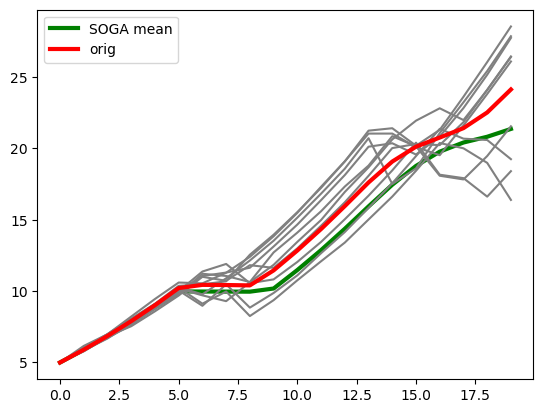

In [7]:
# Optimization in SOGA


# Define the optimizer with init_mean as the parameter
params_dict = initialize_params(init_params)

# Define loss
loss = lambda dist : neg_log_likelihood(orig_traj, dist, idx)

# cfg for SOGA
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/Gearbox2.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

# gradient based optimization
loss_list = optimize(cfg, params_dict, loss, n_steps=200, lr=0.30)

# print results:
for key, value in params_dict.items():
    print(f"{key}: {value.item()}")

# plots the final result
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/Gearbox2.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict)
plt.plot(range(T), output_dist.gm.mean()[:T].detach(), lw=3, color='green', label='SOGA mean')
plot_traj_set(orig_traj, single_traj=10, color='red', label='orig')

y = []
y_var = []
for i in range(20):
    y.append(output_dist.gm.mean()[output_dist.var_list.index('v['+ str(i) +']')].detach().numpy())
    y_var.append(torch.sqrt(output_dist.gm.cov()[output_dist.var_list.index('v['+ str(i) +']'), output_dist.var_list.index('v['+ str(i) +']')]).detach().numpy())

df = pd.DataFrame({'Y_mean': y, 'Y_std': y_var})
df.to_csv('gearbox_opt.csv', index=False)


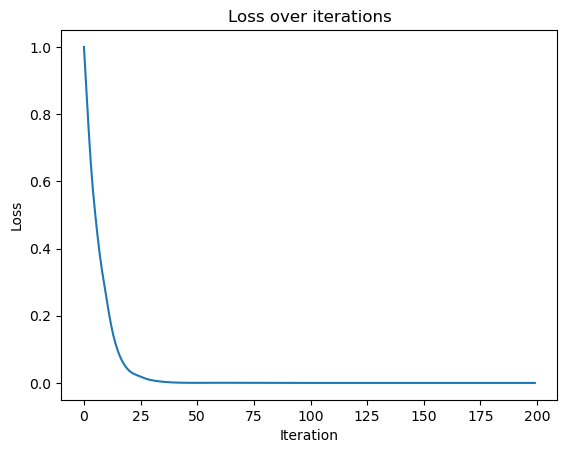

In [8]:
# export loss_list to csv
loss_list = (np.array(loss_list) - np.min(loss_list)) / (np.max(loss_list) - np.min(loss_list))

df_loss = pd.DataFrame({'Loss': loss_list})
df_loss.to_csv('gearbox_loss.csv', index=False)

#plot

plt.plot(df_loss['Loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over iterations')
plt.show()

## Pyro

In [9]:
from cps.pyro_models import *

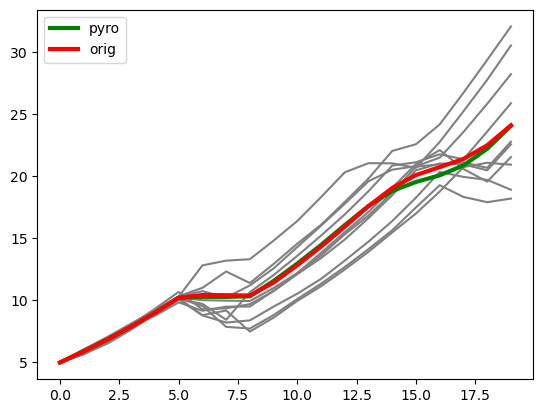

In [10]:
# This is to check that the model works as expected for the right values of the parameters

T = 20
gear = 1
init_v = 5.

def gearbox_pyro_proof(batch_size, eps=1.0):
    
    s1 = pyro.sample("s1", dist.Normal(10., 1.0))
    s2 = pyro.sample("s2", dist.Normal(20., 1.0))

    traj = torch.zeros(batch_size, T)
    traj[:, 0] = init_v

    w = torch.zeros(batch_size)
    gear = torch.ones(batch_size, dtype=torch.long)
    nxt = torch.zeros(batch_size, dtype=torch.long)
    alpha = [0.78, 0.78, 0.78, 0.55, 0.25]
    s = torch.stack([s1, s2])

    dt = 0.1

    for i in range(1, T):
        
        # update gear
        for b in range(batch_size):

            #update velocity
            if gear[b] >= 1:
                traj[b, i] = traj[b, i-1] + dt*traj[b, i-1]*alpha[gear[b]-1] + dt*distributions.Normal(5., 1.).rsample() 
            else:
                traj[b, i] = traj[b, i-1] - dt*0.0005*traj[b, i-1]**2 + distributions.Normal(0., 1.).rsample() 

            # update gear
            if gear[b] >= 1 and gear[b] < 3 and traj[b, i] > s[gear[b]-1]:
                nxt[b] = gear[b] + 1
                gear[b] = 0
                w[b] = 0.2
            elif gear[b] == 0 and w[b] < 0:
                gear[b] = nxt[b]
        
            w[b] = w[b] - dt

    return traj

pyro_traj = gearbox_pyro_proof(batch_size=1000)

plot_traj_set(pyro_traj, single_traj=10, color='green', label='pyro')
plot_traj_set(orig_traj, single_traj=0, color='red', label='orig')

### MCMC

In [11]:
init_params = {'T': 20,   # time steps
               'init_v': 5.,  # initial velocity
               'gear': 1,      # initial gear
               's1': torch.tensor(8.),       # shift points
               's2': torch.tensor(12.)}


gearbox_pyro = create_gearbox_pyro(init_params, eps=2.0)

# does not converge (low acc. prob)
posterior_samples = run_NUTS(gearbox_pyro, orig_traj, num_samples=500, warmup_steps=50, adapt_step_size=True, step_size=1e-3)

Sample:  55%|█████▍    | 302/550 [04:26,  1.13it/s, step size=4.00e-13, acc. prob=0.002]

KeyboardInterrupt: 

In [ ]:
opt_params = {'T': 20,   # time steps
               'init_v': 5.,  # initial velocity
               'gear': 1,      # initial gear
               's1': posterior_samples['s1'].mean().item(),       # shift points
               's2': posterior_samples['s2'].mean().item()}

gearbox_pyro = create_gearbox_pyro(opt_params, eps=2.0)


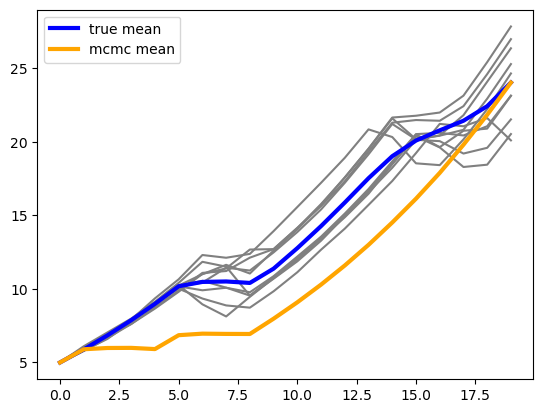

In [ ]:
mcmc_traj = generate_traj(gearbox, 100, opt_params)

plot_traj_set(orig_traj, single_traj=10, color='blue', label='true mean')
plot_traj_set(mcmc_traj, single_traj=0, color='orange', label='mcmc mean')

### VI Optimization

In [ ]:
init_params = {'T': 20,   # time steps
               'init_v': 5.,  # initial velocity
               'gear': 1,      # initial gear
               's1': torch.tensor(8.),       # shift points
               's2': torch.tensor(12.)}


Step 0: Loss = 41711.08974391222
Step 100: Loss = 45713.18992948532
Step 200: Loss = 44462.256715774536
Step 300: Loss = 38872.582023739815
Step 400: Loss = 38849.37370407581
Step 500: Loss = 39994.77201402187
Step 600: Loss = 39717.160367012024
Step 700: Loss = 39520.7787463665
Step 800: Loss = 47092.105803489685
Step 900: Loss = 41020.531078636646
Optimization performed in 3596.04 seconds


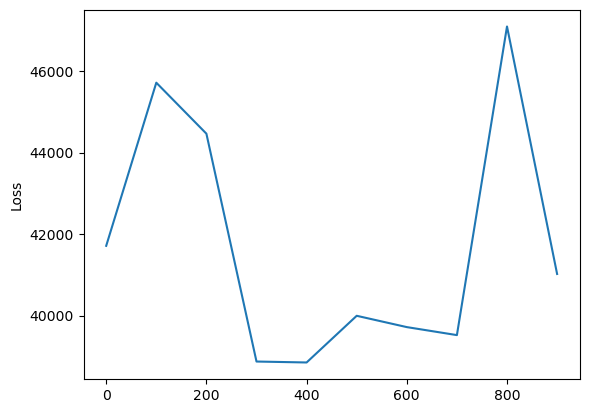

In [ ]:
#gearbox_pyro = create_gearbox_pyro(init_params, eps=1.0)

gearbox_guide = create_gearbox_guide(init_params)

run_SVI(gearbox_pyro, gearbox_guide, orig_traj, num_steps=1000, lr=0.01, num_particles=1, loss_plot=True)

Optimized s1: 8.107597351074219, s2: 11.863809585571289


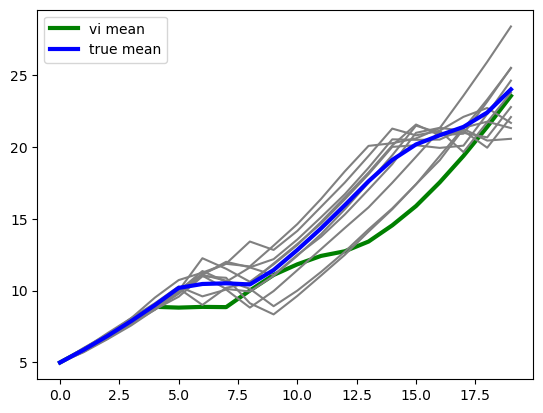

In [ ]:
# Retrieve optimized parameters
vi_s1 = pyro.param("s1_loc").item()
vi_s2 = pyro.param("s2_loc").item()

print(f"Optimized s1: {vi_s1}, s2: {vi_s2}")

# plot

vi_traj = generate_traj(gearbox, 100, {'T': 20,
                                        'init_v': 5.,
                                        'gear': 1,
                                        's1': vi_s1,
                                        's2': vi_s2})
plot_traj_set(vi_traj, single_traj=0, color='green', label='vi mean')
plot_traj_set(orig_traj, single_traj=10, color='blue', label='true mean')

